In [1]:
# Copyright 2020- IBM Inc. All rights reserved
# SPDX-License-Identifier: Apache-2.0

This Notebook evaluates the performance of several object trackers, and the optflow_region_tracker, using synthetic "endoscopic" videos, which are generated as followed:
* An intial frame is read from file
  * a slightly smaller "inner frame" will be used and moved around, so it can be translated a little without having to extrapolate data
* A number of random ROIs are generated
* The trackers are initialized with the initial frame and the random ROIs
* For `n_frames` iterations:
  * a random perspective transform is generated and applied to the original frame as well as the corners of all the ROIs
  * the inner frame is translated on the transformed original frame
  * the same translation is applied to the transformed ROI corners
  * the `frame_generator` generator takes care of the above steps
  * random reflections are added to the frame
  * the trackers update with the transformed, cropped-translated frame with added reflection
  * the true locations of the original ROIs are now quadrilateral, but not rectangles. The Jaccard index of the trackers' predicted ROI positions (rectangles) and the true ROI locations is stored for each tracker and each ROI

At the end of this process, there is a Jaccard index for each ROI, each frame, each tracker

In [1]:
import importlib, time, os, itertools, sys
from string import Template
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath('../optflow_region_tracker/'))
from performance_eval import video_generation as vg
import optflow_region_tracker as ofh

In [7]:
# see https://stackoverflow.com/questions/33358611/ipython-notebook-writefile-and-execute-cell-at-the-same-time
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

## Helper functions

In [3]:
cv2_types_of_trackers = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
# not using 'GOTURN' --> requires additional model weights to be downloaded
# 'MOSSE' --> Doesn't even track past the first frame
# ['MIL', 'TLD'] are quite slow (order 10x slower than rest)
def generate_cv2_tracker(type_of_tracker):
    """
    Create object tracker.
    """
    if type_of_tracker == cv2_types_of_trackers[0]:
        tracker = cv2.TrackerBoosting_create()
    elif type_of_tracker == cv2_types_of_trackers[1]:
        tracker = cv2.TrackerMIL_create()
    elif type_of_tracker == cv2_types_of_trackers[2]:
        tracker = cv2.TrackerKCF_create()
    elif type_of_tracker == cv2_types_of_trackers[3]:
        tracker = cv2.TrackerTLD_create()
    elif type_of_tracker == cv2_types_of_trackers[4]:
        tracker = cv2.TrackerMedianFlow_create()
    elif type_of_tracker == cv2_types_of_trackers[5]:
        tracker = cv2.TrackerGOTURN_create()
    elif type_of_tracker == cv2_types_of_trackers[6]:
        tracker = cv2.TrackerMOSSE_create()
    elif type_of_tracker == cv2_types_of_trackers[7]:
        tracker = cv2.TrackerCSRT_create()
    else:
        tracker = None
        print('The name of the tracker is incorrect')
        print('Here are the possible trackers:')
        for track_type in cv2_types_of_trackers:
                      print(track_type)
        raise ValueError
    return tracker

def generate_cv2_multitracker(type_of_tracker, frame0, ROIs):
    multitracker = cv2.MultiTracker_create()
    for rr in ROIs:
        multitracker.add(generate_cv2_tracker(type_of_tracker), frame0, tuple(rr))
    return multitracker

def generate_optflow_tracker(frame0, ROIs, fit_flow_fun, label=None):
    dis = cv2.optflow.createOptFlow_DIS(cv2.optflow.DISOPTICAL_FLOW_PRESET_MEDIUM)
    label=' '.join(('DIS_flow',fit_flow_fun)) if label is None else label
    return ofh.optflow_tracker(dis, frame0,
            ROIs,
            fit_flow_fun=fit_flow_fun,
            label=label,
            convert_to_gray=True,
            forward_backward=False)  

def random_rois(n=1, frame_wh=(480,360), min_wh_max_wh=(15,15,45,45), margin_xy=(20,20)):
    """Generate random ROIs (left, top, width, height) within the provided parameters"""
    w,h = frame_wh
    mx, my = margin_xy
    C1 = np.hstack( (np.random.randint(mx, w-mx-min_wh_max_wh[0], size=(n,1))   ,
                        np.random.randint(my, h-my-min_wh_max_wh[1], size=(n,1)   ),
                        np.random.randint(min_wh_max_wh[0], min_wh_max_wh[2], size=(n,1)),  
                        np.random.randint(min_wh_max_wh[1], min_wh_max_wh[3], size=(n,1))  
                    )   )
    # these are the indices where the [right, top] exceeds the margins
    exceeding = (C1 @ np.array([[1,0,1,0],[0,1,0,1]]).T) > np.array([[w-mx, h-my]])
    # we fix this by moving them [left,up]
    C1[exceeding[:,0], 0] -= (min_wh_max_wh[2]-min_wh_max_wh[0])
    C1[exceeding[:,1], 1] -= (min_wh_max_wh[3]-min_wh_max_wh[1])
    return C1 

def rects_to_corners(rects: np.array):
    """Convert [left, top, width, height] rectangles into representation by the 4 corners.
    In: (n,4) array, each row a rectangle
    Out: (4*n, 2) array, each rectangle a (4,2) block of (x,y) coordinates"""
    return np.vstack(
        [r[:2]+np.array([[0,0],[r[2],0],[r[2],r[3]],[0,r[3]]]) for r in rects ]
    )
def corners_to_rects(corners):
    """Inverse of `rects_to_corners`"""
    return np.vstack(
        [ [corners[ii+0,0], corners[ii+0,1],corners[ii+1,0]-corners[ii+0,0], corners[ii+2,1]-corners[ii+1,1]]
         for ii in np.arange(0,corners.shape[0], step=4)
         ]
    )
def plot_rect(rect, ax, **kwargs):
    """plot the rectangle `rect` in axis `ax`."""
    x,y,w,h = rect
    ax.plot( [x, x+w, x+w, x, x], [y, y, y+h, y+h, y], **kwargs  )
def plot_rect_cv2(rect, frame, **kwargs):
    """draw rectangle `rect` onto `frame` using cv2.rectangle.
    NOTE: `frame` is mutated."""
    x,y,w,h = rect
    cv2.rectangle(frame, (int(x), int(y)), (int(x+w), int(y+h)), **kwargs)

# Config Cell

In [8]:
%%write_and_run tmp.txt
# initial frames to generate videos from
data_folder = os.path.abspath('../data/frames/')  #  this folder should contain some frames that can be used for video generation
frame0_filenames = sorted(os.listdir(data_folder))
n_frames0 = len(frame0_filenames)
# numpy file to store stuff in
results_store_folder = os.path.expanduser('~/tmp/MICCAI2022/')  #  will throw exception if folders don't exist
npz_filename_template = Template("PerfEvalResults_${timestamp}.NPZ")
# if videos are to be stored
video_store_folder = os.path.expanduser('~/tmp/MICCAI2022/') #  will throw exception if folders don't exist
videofilename_template =  Template( 
                os.path.join( video_store_folder, "${frame0_name}_${timestamp}s.MP4")
)

# things to iterate over
n_frames = 50
n_frames_slow = 10  #  number of frames the slow trackers get to track
n_rois = 10
max_rots_deg = [0.0, 5.0, 10.0]  # in deg
N_reflections = [0, 10, 25]  # Needs to be int type! 
refl_size_minmax = (8,30)

# cv2 Trackers
cv2trackers_to_use = [ 'KCF', 'MEDIANFLOW', 'BOOSTING','CSRT', 'MIL', 'TLD']
slow_trackers_last_n = 4  #  designates the trackers cv2trackers_to_use[-slow_trackers_last_n:] as slow 
n_cv2trackers_fast = len(cv2trackers_to_use) - slow_trackers_last_n

# our Tracker
fit_flow_funs = ['median','affine']
n_our_tracker = len(fit_flow_funs)
# frame generation
WH = (440,330)
max_shear=3
max_translation_speed=3
min_max_elation_scale=(.95,1.04)
min_max_scale=(.97,1.03)

reflection_blur = (int(2*(refl_size_minmax[0]//2)+1), )*2
# ROI generation
margin_xy=(50,50)
min_wh_max_wh=(20,20,80,90)

# Pre-alloc
JACC = np.zeros(
    shape=(
        n_frames, n_frames0, n_rois, len(N_reflections), len(max_rots_deg), n_our_tracker + n_cv2trackers_fast
            )
    ) + np.nan
JACC_slow = JACC[:n_frames_slow, ..., -slow_trackers_last_n:].copy()
T_update = np.zeros(
    shape=(n_frames0, len(N_reflections), len(max_rots_deg), n_our_tracker+n_cv2trackers_fast+slow_trackers_last_n),
          dtype=np.single)
# FLAGS
store_videos_FLAG = False
# the video storage isn't yet implemented

# LOOP
Indexing: `n_frames, n_frames0, n_rois, N_reflections, max_rot, tracker`

In [ ]:
config_cell_filename = f"Config_cell_{time.strftime('%Y%m%d_%H%M%S')}.txt"
npz_file = npz_filename_template.substitute(timestamp=time.strftime('%Y%m%d_%H%M%S'))
os.rename("tmp.txt", os.path.join(results_store_folder, config_cell_filename))
# That's the last execution of the config cell above
t0 = time.perf_counter()
for ff00, frame0_fname in enumerate(frame0_filenames):
    frame0 = cv2.imread(os.path.join(data_folder, frame0_fname))
    # generate ROIs
    ROIs = random_rois(n=n_rois, frame_wh=WH, margin_xy=margin_xy, min_wh_max_wh=min_wh_max_wh)
    ROI_corners = rects_to_corners(ROIs)
    for mmrr, max_rot in enumerate(max_rots_deg):
        max_rot = max_rot*np.pi/180
        framegen = vg.frame_generator(
            frame0,
            points=ROI_corners,
            wh=WH,
            max_shear=max_shear,
            max_translation_speed=max_translation_speed,
            min_max_elation_scale=min_max_elation_scale,
            min_max_scale=min_max_scale,
            max_rot=max_rot
        )
        frame00, _ = next(framegen)
        if store_videos_FLAG:
            frame_to_draw_on = frame00.copy()
            # rest about video gen here
        trackers = [ 
                    [generate_optflow_tracker(frame00, ROIs, fit_flow_fun) for fit_flow_fun in fit_flow_funs] + 
                    [generate_cv2_multitracker(tracker_type, frame00, ROIs) for tracker_type in cv2trackers_to_use]
                    for n_reflection in N_reflections
                    ]
        for ff in range(n_frames):
            # produce next reflection-free frame
            nxt_frame, nxt_pts = next(framegen)
            if store_videos_FLAG: frame_to_draw_on = nxt_frame.copy()
            # now for each number of reflections, update tracker etc
            for nnrr, n_reflection in enumerate(N_reflections):
                if n_reflection>0:
                    # reflections
                    refl_origins = np.hstack((np.random.randint(0,WH[0],(n_reflection,1)),
                        np.random.randint(0,WH[1],(n_reflection,1))
                        ))
                    refl_sizes = np.random.randint(refl_size_minmax[0], refl_size_minmax[1], (n_reflection,2), dtype=int)
                    rand_reflections = np.dstack( [
                        vg.synthetic_reflection(WH, refl_origins[r,:], el_size_wh=tuple(refl_sizes[r,:]), blur=reflection_blur)
                                        for r in range(n_reflection)] )
                    R = np.sum( rand_reflections*(rand_reflections/255.), axis=2, keepdims=True)                
                    nxt_frame_reflections = np.uint8( nxt_frame*(1-R/255.) + R*(R/255.) )
                else:
                    nxt_frame_reflections = nxt_frame.copy()
                # update all the trackers
                # leave out the slow trackers after n_frames_slow
                slice_in_use = slice(0, None if ff<n_frames_slow else -slow_trackers_last_n)
                tracker_returns = []
                for tt, tracker in enumerate(trackers[nnrr][slice_in_use]):
                    t00 = time.perf_counter()
                    tracker_return = tracker.update(nxt_frame_reflections)
                    T_update[ff00, nnrr, mmrr, tt]+=(time.perf_counter()-t00)
                    tracker_returns.append( tracker_return )
                for tt in range(0, n_our_tracker):
                    for rroii, roi in enumerate(trackers[nnrr][tt].rois):
                        JACC[ff, ff00, rroii, nnrr, mmrr, tt] = vg.polygon_rect_IoU( nxt_pts[rroii*4:4*rroii+4,:], roi.as_int() )
                for tt in range(2,n_our_tracker+n_cv2trackers_fast):
                    succ, new_rois2 = tracker_returns[tt]
                    for rroii, rect in enumerate(new_rois2):
                        JACC[ff, ff00, rroii, nnrr, mmrr, tt] = np.nan if not succ else \
                                                                        vg.polygon_rect_IoU(nxt_pts[rroii*4:4*rroii+4,:], rect )
                if ff<n_frames_slow:
                    for tt in range(slow_trackers_last_n):
                        succ, new_rois2 = tracker_returns[-(tt+1)]
                        for rroii, rect in enumerate(new_rois2):
                            JACC_slow[ff, ff00, rroii, nnrr, mmrr, slow_trackers_last_n-(tt+1)] = np.nan if not succ else \
                                                                            vg.polygon_rect_IoU(nxt_pts[rroii*4:4*rroii+4,:], rect )
        print(f'this took {time.perf_counter()-t0}s')
#         break
#     break              
# Store the results     
np.savez_compressed(os.path.join(results_store_folder, npz_file),
                    config_cell_filename=config_cell_filename,
                    T_update=T_update,
                    JACC_slow=JACC_slow,
                    JACC=JACC,
                    cv2trackers_to_use=cv2trackers_to_use,
                    slow_trackers_last_n=slow_trackers_last_n,
                    n_frames=n_frames, n_frames_slow=n_frames_slow,
                    max_rots_deg=max_rots_deg,
                    fit_flow_funs=fit_flow_funs,
                    N_reflections=N_reflections,
                    total_runtime=(time.perf_counter()-t0)
                   )

this took 61.6150567040022s
this took 131.20866174600087s
this took 193.4226039020068s
this took 253.5186637700026s
this took 313.68113333700603s
this took 371.5463719340041s
this took 431.0297729810045s
this took 491.5662630190054s
this took 552.5781851630018s
this took 613.8372333020016s
this took 672.4799528680014s
this took 730.6897572310045s
this took 786.2608002430061s
this took 842.478254888003s


# Below here: Scratchpaper

In [15]:
n_frames_counted = np.zeros((len(trackers[0]),))+n_frames; n_frames_counted[-slow_trackers_last_n:] = n_frames_slow
T_update[0,2,0,:]/n_frames_counted

array([0.02543059, 0.03565502, 0.04054111, 0.0188827 , 0.18693552,
       0.18376849, 0.37831185, 0.24896195])

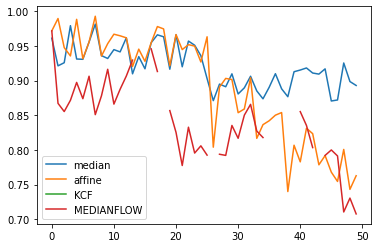

In [14]:
plt.plot(JACC[:,0,0,2,0,:])
plt.legend(fit_flow_funs+cv2trackers_to_use)

In [27]:
#

frame = cv2.imread('~/Downloads/Angiodysplasie.jpg')[100:,100:,:]
h,w = frame.shape[:2]
WH = (w-2*margin_xy[0], h-2*margin_xy[1])
n_rois = 1
ROIs = random_rois(n=n_rois, frame_wh=WH, margin_xy=margin_xy, min_wh_max_wh=min_wh_max_wh)
ROI_corners = rects_to_corners(ROIs)
N_frames = 300
# reflections
N_reflections = 0


jacc_indices = np.zeros((N_frames, n_rois, 1+len(cv2trackers_to_use))) + np.nan

framegen = vg.frame_generator(
    frame,
    points=ROI_corners,
    wh=WH,
    max_shear=max_shear,
    max_translation_speed=max_translation_speed,
    min_max_elation_scale=min_max_elation_scale,
    min_max_scale=min_max_scale,
    max_rot=5*np.pi/180
)

frame0, _ = next(framegen)  # returns the undistorted frame

# fit_flow_fun = 'median'
# dis = cv2.optflow.createOptFlow_DIS(cv2.optflow.DISOPTICAL_FLOW_PRESET_MEDIUM)
# tracker = ofh.optflow_tracker(dis, frame0,
#             ROIs,
#             fit_flow_fun=fit_flow_fun,
#             label=' '.join(('DIS_flow',fit_flow_fun)),
#             convert_to_gray=True,
#             forward_backward=False)         
# tracker.time_spent_updating = 0.0

# cv2tracker = [ cv2.MultiTracker_create() for tt in cv2trackers_to_use]
# cv2tracker_time_spent_updating = [0.0]*len(cv2tracker)
# for ii,tt in enumerate(cv2trackers_to_use):
#     for rr in ROIs:
#         cv2tracker[ii].add(generate_tracker(tt), frame0, tuple(rr))



In [47]:
# writer = cv2.VideoWriter(f'~/tmp/test_{time.strftime("%Hh%M")}.mp4', cv2.VideoWriter_fourcc(*'avc1'), 5, WH, True)
# If adding fake NIR:
writer = cv2.VideoWriter(f'~/tmp/test_{time.strftime("%Hh%M")}.mp4', cv2.VideoWriter_fourcc(*'avc1'), 5, (WH[0], 2*WH[1]), True)
def fake_NIR(vis, nframe, channel=0):
    t = n_frame/N_frames
    x = 4 * t * (1-t)
    return np.dstack( (vis[:,:,channel]*x + 5*np.random.rand(WH[1], WH[0]),)*3).astype(np.uint8)
    
frame00 = frame0.copy()

# for ii in range(0,ROI_corners.shape[0],4):
#         cv2.polylines(	frame00, [ROI_corners[ii:ii+4,:].astype(np.int32)], True, (0,255,0))
writer.write(frame00)
n_frame = 0
jacc_indices[n_frame, :] = 1
for jj in range(N_frames):
    nxt_frame, nxt_pts = next(framegen)
    # reflections
    refl_origins = np.hstack((np.random.randint(0,WH[0],(N_reflections,1)),
                        np.random.randint(0,WH[1],(N_reflections,1))
                        ))
    refl_sizes = np.random.randint(refl_size_minmax[0], refl_size_minmax[1],
                                    (N_reflections,2), dtype=int)
    if N_reflections>0:
        rand_reflections = np.dstack( [
vg.synthetic_reflection(WH, refl_origins[r,:], el_size_wh=tuple(refl_sizes[r,:]), blur=True)
                    for r in range(N_reflections)] )
        R = np.sum( rand_reflections*(rand_reflections/255.), axis=2, keepdims=True)                
        nxt_frame = np.uint8( nxt_frame*(1-R/255.) + R*(R/255.) )
    else:
        pass
    frame_to_draw_on = nxt_frame.copy()
    t0 = time.perf_counter()
# Trackers:
#     succ = tracker.update(nxt_frame)
#     tracker.time_spent_updating+=(time.perf_counter()-t0)
#     for rr, roi in enumerate(tracker.rois):
#         jacc_indices[n_frame, rr, 0] = vg.polygon_rect_IoU(
#             nxt_pts[rr*4:4*rr+4,:],
#             roi.as_int()        )
#     for ii, cv2tt in enumerate(cv2tracker):
#         t0 = time.perf_counter()
#         succ2, new_rois2 = cv2tt.update(nxt_frame)
#         cv2tracker_time_spent_updating[ii]+=(time.perf_counter()-t0)
#         # compute IoU and draw results on frame 
#         for rr, rect in enumerate(new_rois2):
#             jacc_indices[n_frame, rr, 1+ii] = np.nan if not succ2 else \
#                 vg.polygon_rect_IoU(nxt_pts[rr*4:4*rr+4,:], rect )
#             color = (250,250*rr,250) if succ2 else (0,0,255)
#             plot_rect_cv2(rect, frame_to_draw_on, color=color)
#     frame_to_draw_on = tracker.overlay_rois(frame_to_draw_on, color=((255,0,0), (0,0,255)))
# Draw the true ROI locations
#     for ii in range(0,nxt_pts.shape[0],4):
#         cv2.polylines(frame_to_draw_on, [nxt_pts[ii:ii+4,:].astype(np.int32)], True, (0,255,0))#[, thickness[, lineType[, shift]]]	) -> 	img    writer.write()
#     writer.write(frame_to_draw_on)
    writer.write(np.vstack( (frame_to_draw_on, fake_NIR(nxt_frame, n_frame) ) ) )

    n_frame+=1
writer.release()

In [31]:
print([tt for tt in ['MO']+cv2trackers_to_use])
print([tracker.time_spent_updating] + cv2tracker_time_spent_updating)

['MO', 'BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'CSRT']
[0.5486209600094298, 3.7604425990066375, 10.22756658900471, 0.5674730649989215, 8.252706274997763, 0.29360711401022854, 4.621811081011401]


In [ ]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
linestyles = itertools.cycle(['-', '--',':','-.'])
for ii,cc in zip(range(jacc_indices.shape[-1]), linestyles):
    ax[0].plot(jacc_indices[:,:,ii], linestyle=cc)
ax[0].legend([i for i in range(n_rois)])

Pctl = np.nanpercentile(jacc_indices, [50,25,75], axis=(1))
ax[1].plot(Pctl[0,...])
ax[1].legend([tt for tt in ['MO']+cv2trackers_to_use])
print([tt for tt in ['MO']+cv2trackers_to_use])
print(np.nanpercentile(jacc_indices, [50,25,75], axis=(0,1)))

0.0


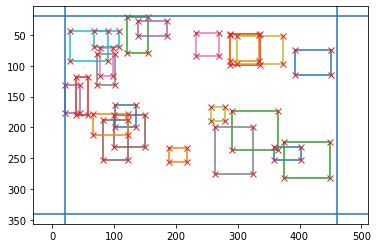

In [4]:
## Try the random generation of ROIs
R = random_rois(n=23, min_wh_max_wh=(20,20,80,80))
# check if conversion between [l,t,w,h] and corners is correct
Rc = rects_to_corners(R)
R2 = corners_to_rects(Rc)
print(np.linalg.norm(R-R2))
#
ax = plt.axes()
for r in R2:
    plot_rect(r, ax)
plt.plot(Rc[:,0], Rc[:,1],'x')
plt.axis('tight')
ax.axvline(20); ax.axvline(460)
ax.axhline(20); ax.axhline(340)
plt.axis('equal'); ax.invert_yaxis()
